# Homework 4

These are the libraries we use to perform our analysis.

In [1]:
import requests
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize
import time
import math
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_similarity_score
import matplotlib.pyplot as plt
import re
import time
import warnings
import json
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## 1) Does basic house information reflect house's description?

### Retrieving announcements

First of all we use **Beautiful soup** to retrieve announcements from the site **immobiliare.it**. This step takes some hours so we get the valid announcements and save it into the **records_list** .txt file. You can find the *web_scraping* in the script called **Web_scraping_immobiliare**.



We want to build two matrices: the first one $m_{ij}$ with {prezzo, locali, superficie, bagni, piano} for each announcement and the second one with the tfidf value of each word in each document. In addition to this we need the entire description of each announcement.
Actually we look at almost $700$ pages since we need $10K$ documents.

In [2]:
# retrieving the records list
with open("records_list.txt", "rb") as fp: 
    records = pickle.load(fp)

In [3]:
len(records)

10866

Actually we obtained $10866$ announcements but in order to save memory (and prevent memory error) we take only the first $10K$ announcements, so truncate our list.

In [4]:
# taking only the first 10000 announcement
records = records[:10000]

# number of announcements
num_announc = len(records)
num_announc

10000

### Creating items dataframe

With the informations stored in **records** list we can create the first dataframe where the **announcement_i** is on the row and *['annuncio', 'prezzo', 'locali', 'superfici', 'bagni', 'piano', 'descrizione']* are on columns. 

In [5]:
df = pd.DataFrame(records, columns = ['annuncio', 'prezzo', 'locali', 'superfici', 'bagni', 'piano', 'descrizione'])
df.head()

,annuncio,prezzo,locali,superfici,bagni,piano,descrizione
0,announcement_1,€ 225.000,2,50,1,1,PAPILLO EUR in elegante complesso residenziale...
1,announcement_2,€ 375.000,3,120,1,3,"Pigneto, Appartamento in Vendita, libero lumin..."
2,announcement_3,€ 68.000,2,20,1,0,Rif: 18066 - TRIESTE - Via della Fontana. Nell...
3,announcement_4,€ 450.000,5,150,2,3,Zona EUR - Viale Cesare Pavese - Via Salvatore...
4,announcement_5,€ 315.000,3,92,2,5,Fino al 31/12/2018 le spese relative l’onorari...


By taking a look at our dataframe we notice that there are some oddities, like '\xa0' or '+' characters so we clean the columns by removing them. Furthermore we need only numeric items to make clusters, thus we rewrite the prices (removing dots and the euro symbol).

In [6]:
df['locali'] = df['locali'].str.replace('\xa0', '')
df['locali'] = df['locali'].str.replace('+', '')
df['bagni'] = df['bagni'].str.replace('\xa0', '')
df['bagni'] = df['bagni'].str.replace('+', '')
df['superfici'] = df['superfici'].str.replace('\xa0', '')
df['superfici'] = df['superfici'].str.replace('.', '')
df['piano'] = df['piano'].str.replace('\xa0', '')
df['prezzo'] = df['prezzo'].str.replace('€', '')
df['prezzo'] = df['prezzo'].str.replace('.', '')

When we create the dataframe from the list we obtain some *NaN* values: that's because *pandas* fill the zero values with *NaN* thus we force these values to be zeroes.

In [7]:
# replacing NaN value with 0
df['piano'] = df['piano'].fillna(0)

Now we can convert the strings to *int* type by using the *numpy* library.

In [8]:
# converting the columns items into integers
df['locali'] = df['locali'].astype(np.int64)
df['superfici'] = df['superfici'].astype(np.int64)
df['bagni'] = df['bagni'].astype(np.int64)
df['piano'] = df['piano'].astype(np.int64)
df['piano'] = df['piano'].astype(np.int64)
df['prezzo'] = df['prezzo'].astype(np.int64)

In [9]:
df.head()

,annuncio,prezzo,locali,superfici,bagni,piano,descrizione
0,announcement_1,225000,2,50,1,1,PAPILLO EUR in elegante complesso residenziale...
1,announcement_2,375000,3,120,1,3,"Pigneto, Appartamento in Vendita, libero lumin..."
2,announcement_3,68000,2,20,1,0,Rif: 18066 - TRIESTE - Via della Fontana. Nell...
3,announcement_4,450000,5,150,2,3,Zona EUR - Viale Cesare Pavese - Via Salvatore...
4,announcement_5,315000,3,92,2,5,Fino al 31/12/2018 le spese relative l’onorari...


### Creating descriptions dataframe

In order to work with descriptions, we define the **preprocess** function which preprocesses a text: in particular we swap upper case to lower, remove the new_line command, punctuation and finally stem the text.

In [10]:
def preprocess(text):
    text = text.lower()
    # removing '\n'
    text = text.replace('\\n', ' ')
    # removing punctuation
    tokenizer = regexp_tokenize(text, "[\w\$]+")
    # filter the non stopwords
    filtered = [w for w in tokenizer if not w in stopwords.words('italian')]
    ps = PorterStemmer()
    # removing the stem
    filtered = [ps.stem(word) for word in filtered]
    return filtered

We recall the **preprocess** function in the *for* loop in the *records* list so we obtain a nested list where each item is the list of preprocessed words of each announcement descriprion.

In [11]:
# processed is a nested list 
# each item is a list of preprocessed words of each announcement without repetitions
processed = []
for announcement in tqdm(records):
    # we want to preprocess only the announcement description
    processed.append(list(set(preprocess(announcement[-1]))))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:46<00:00, 17.05it/s]


Again we make some cleaning in our data: we don't need to work with numeric strings thus we remove them, they are not significant in our analysis.

In [12]:
# removing the numeric string from the preprocessed words
for li_ in tqdm(processed):
    for str_ in li_:
        if (str_.isnumeric() == True):
            li_.remove(str_)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 49256.27it/s]


In order to compute the **tfidf** of each word we want to store both the *preprocessed* list and a *flatten* one thus we have a list of the preprocessed words without repetitions. 

In [13]:
# flatten list with repetitions
tot_proc = []
for li_ in tqdm(processed):
    for str_ in li_:
        tot_proc.append(str_)

# flatten list without repetitions
tot_unique = list(set(tot_proc))

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 53336.93it/s]


We have to work with many words and many (a lot of) word occurrencies so we decide to create two dictionaries:
* word_tot_occ = {'word': tot_occurrencies}
* word_doc_occ = {'word': {doc: tot_occ_doc}}

The **word_tot_occ** stores the words and the documents in which they occurr while **word_doc_occ** stores the words and as values a subdict which cointains the **doc** and the word occurence in that doc.

In [14]:
word_tot_occ = {}
for word in tqdm(tot_unique):
    for li_ in processed:
        if word in li_:
            if word not in word_tot_occ:
                word_tot_occ[word] = 0
            if word in word_tot_occ:  
                word_tot_occ[word] += 1
        else:
            pass

100%|████████████████████████████████████████████████████████████████████████████| 22534/22534 [07:38<00:00, 49.20it/s]


In [15]:
len(word_tot_occ)

22534

In [16]:
smallest_values = [word for word in word_tot_occ.keys() if word_tot_occ[word] == 1]

In [17]:
len(smallest_values)

8974

In [18]:
biggest_values = [word for word in word_tot_occ.keys() if word_tot_occ[word] > 7000]

In [19]:
len(biggest_values)

4

To perform a good analysis we drop off the *outliers*, i.e. we delete from our dictionaries those words which occur rarely (once for example) or too many times (they are not significant).

In [20]:
# just a copy of the previous dict (with outliers)
word_with_out = word_tot_occ

In [21]:
keys = list(word_tot_occ.keys())
# we append the outliers key to a list in order to remove them from the analysis below
outliers_keys = []
for key in keys:
    if (word_tot_occ[key] < 2) or (word_tot_occ[key] > 7000):
        outliers_keys.append(key)
        del word_tot_occ[key]

In [22]:
len(outliers_keys)

8978

In [23]:
def create_occ_word(processed, tot_unique):
    word_doc_occ = {}
    for word in tqdm(tot_unique):
        if word in outliers_keys:
            continue
        else:
            word_doc_subdict = {}
            for i, doc in enumerate(processed):
                word_doc_subdict[i] = doc.count(word)
            word_doc_occ[word] = word_doc_subdict
    return word_doc_occ

In [24]:
word_doc_occ = create_occ_word(processed, tot_unique)

100%|████████████████████████████████████████████████████████████████████████████| 22534/22534 [05:35<00:00, 67.23it/s]


In [25]:
len(word_doc_occ)

13556

In [26]:
# it returns a list of tfidf (in each document) for a given word
def tfidf(processed, num_announc, word_doc_occ, word_tot_occ, word):
    tfidf_li = []
    for i in range(len(processed)):
        if (word in processed[i] and word not in outliers_keys):
            tfidf = word_doc_occ[word][i]/len(processed[i]) * math.log(num_announc / word_tot_occ[word])
        else:
            tfidf = 0
        tfidf_li.append(round(tfidf,4))
    return tfidf_li

In [27]:
tfidf_dict = {}
for word in tqdm(tot_unique):
    if word not in outliers_keys:
        li = tfidf(processed, num_announc, word_doc_occ, word_tot_occ, word)
        tfidf_dict[word] = li
    else:
        pass

100%|████████████████████████████████████████████████████████████████████████████| 22534/22534 [09:43<00:00, 38.62it/s]


Creating the list of the announcements names to have it as rows of the second dataframe.

Finally we can create the tfidf dataframe.

In [28]:
tfidf_df = pd.DataFrame(tfidf_dict)
tfidf_df.head()

,fama,personalizzazioni,scoprirai,lamaro,destinar,sevizio,staircas,03,innumerevoli,maria,...,romolo,verandati,contatori,secolar,recintato,dichiarano,principalment,silenziosissima,prato,buona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Clustering

Now it's time to clusterize. First of all we need to convert our pandas dataframes into matrices and to understand which is good number of cluster we have to use. We can check it via Elbow method.

In [29]:
df.drop('annuncio', axis = 1, inplace = True)
df.drop('descrizione', axis = 1, inplace = True)
df.head()

,prezzo,locali,superfici,bagni,piano
0,225000,2,50,1,1
1,375000,3,120,1,3
2,68000,2,20,1,0
3,450000,5,150,2,3
4,315000,3,92,2,5


In [30]:
# converting df and tfidf_df to matrices
df_matrix_val = df.values
tfidf_matrix_val = tfidf_df.values

In [31]:
infos_matrix = df_matrix_val
elbow_items = []

for i in tqdm(range(2,10)):
    km = KMeans(n_clusters = int(i), init = 'k-means++', tol = 0.0001).fit(infos_matrix)
    elbow_items.append(km.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.40it/s]


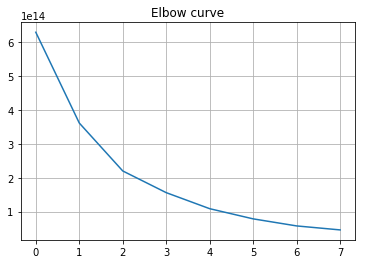

In [32]:
plt.plot(elbow_items)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [33]:
tfidf_matrix = tfidf_matrix_val
elbow = []

for i in tqdm(range(2, 20)):
    km = KMeans(n_clusters = int(i), init = 'k-means++', tol = 0.0001).fit(tfidf_matrix)
    elbow.append(km.inertia_)


100%|███████████████████████████████████████████████████████████████████████████████| 18/18 [1:25:07<00:00, 356.15s/it]


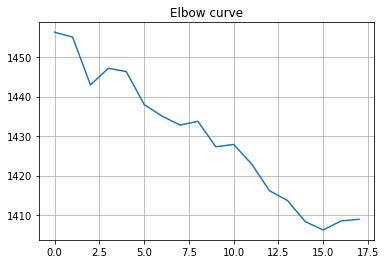

In [34]:
plt.plot(elbow)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

According to the plots we decide to use $2$ clusters for the informative matrix and $7$ for the descriptive one.

In [42]:
def jaccard(a, b):
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [37]:
km = KMeans(n_clusters = 2, init = 'k-means++').fit(df_matrix_val)
km1 = KMeans(n_clusters = 7, init = 'k-means++').fit(tfidf_matrix_val)

In [38]:
labels = km.labels_
labels1 = km1.labels_

In [40]:
# creating empty dicts with the cluster_ids as keys
clusters_items = dict.fromkeys([0, 1, 2])
clusters_tfidf = dict.fromkeys([0, 1, 2, 3])

for key in clusters_items.keys():
    clusters_items[key] = [ann_id for ann_id, cluster in enumerate(labels) if cluster == key]
for key in clusters_tfidf.keys():
    clusters_tfidf[key] = [ann_id for ann_id, cluster in enumerate(labels1) if cluster == key]

In [43]:
sims = []
for i, cluster in enumerate(clusters_items.values()):
    for j, other in enumerate(clusters_tfidf.values()):
        # tuple (jacc_sim, clusters couple)
        sims.append((jaccard(set(cluster), set(other)), i, j))
        
print('These are the three highest results of the jaccard similarities:')
sorted(sims, reverse = True)[:3]

These are the three highest results of the jaccard similarities:


[(0.6578203834510595, 0, 2),
 (0.20023645743766122, 0, 3),
 (0.09416118421052631, 1, 2)]

### Wordcloud

In [35]:
filtered = [w for w in stopwords.words('italian')]
stopwords = set(STOPWORDS)
stopwords.update(filtered)

In [44]:
# list of couples doc_ids
coup1_li = [x for x in clusters_items[0] + clusters_tfidf[3]]
coup2_li = [x for x in clusters_items[2] + clusters_tfidf[3]]
coup3_li = [x for x in clusters_items[0] + clusters_tfidf[1]]

In [45]:
wordcouple1 = [records[i][6] for i in coup1_li]
wordcouple2 = [records[i][6] for i in coup2_li]
wordcouple3 = [records[i][6] for i in coup3_li]

In [46]:
wordcloud1 = ' '.join(x for x in wordcouple1)
wordcloud2 = ' '.join(x for x in wordcouple2)
wordcloud3 = ' '.join(x for x in wordcouple3)

In [47]:
# generate a word cloud image
def generate_wordcloud(stopwords, text):
    wordcloud = WordCloud(stopwords = stopwords).generate(text)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

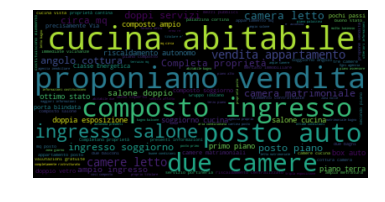

In [48]:
generate_wordcloud(stopwords, wordcloud1)

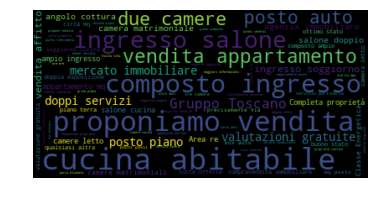

In [49]:
generate_wordcloud(stopwords, wordcloud2)

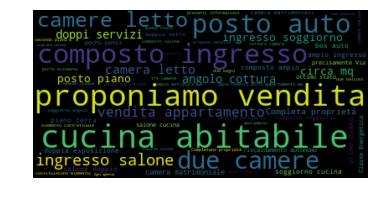

In [50]:
generate_wordcloud(stopwords, wordcloud3)

## 2) Find the duplicates!

In [1]:
from tqdm import tqdm

In [2]:
data = 2
with open('passwords2.txt', 'r') as file:
    data = file.read().split('\n')#[:1000000]

In [4]:
hash_table_size = 137000017

In [4]:
#### last version

In [5]:
def string_mapping(password):
    num_ = 0
    for i, character in enumerate(password):
        i = 19 - i
        ascii_value = ord(character)
        num_ += ascii_value*(256**i)
    return num_

In [6]:
# with order
hash_list1 = [0] * hash_table_size

collisions1 = 0
duplicates1 = 0

for password in tqdm(data):
    num_ = string_mapping(password)
    index = num_ % hash_table_size
    if hash_list1[index] == 0:
        hash_list1[index] = [password]
    elif password in hash_list1[index]:
        duplicates1 += 1
    else:
        hash_list1[index].append(password)
        collisions1 += 1

100%|███████████████████████████████████████████████████████████████| 110000001/110000001 [11:35:18<00:00, 2636.69it/s]


In [7]:
print(duplicates1, collisions1)

5000000 31661128


In [ ]:
# without order
hash_list2 = [0] * hash_table_size

collisions2 = 0
duplicates2 = 0

for password in tqdm(data):
    password = ''.join(sorted(password))
    num_ = string_mapping(password)
    index = num_ % hash_table_size
    if hash_list2[index] == 0:
        hash_list2[index] = [password]
    elif password in hash_list2[index]:
        duplicates2 += 1
    else:
        hash_list2[index].append(password)
        collisions2 += 1

  0%|                                                                                    | 0/110000001 [00:00<?, ?it/s]

In [ ]:
print(duplicates2, collisions2)